## AI Trends Searcher using CrewAI RAG

Using Crew AI to create sophisticated AI news search and writer agents. Using CrewAI RAG create AI Assistants to Run News Agency for AI trends with summarized reports.

This innovative approach combines Retrieving and Generating information, revolutionising how we search for AI news articles, analyse them, and deliver in-depth reports.

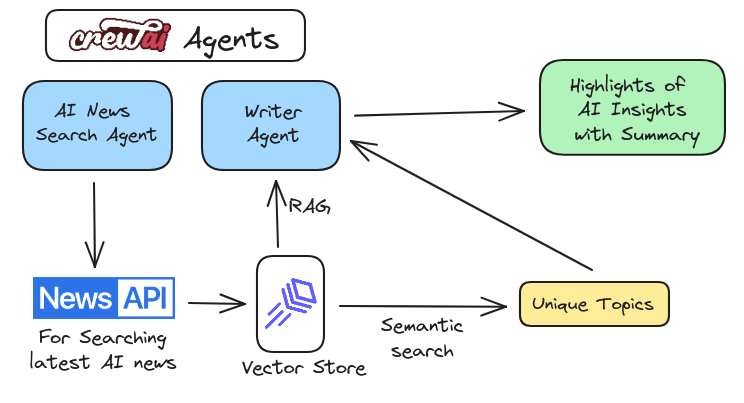

Get Free News API Key at [link](https://newsapi.org/)

### Install required packages


In [1]:
%pip install lancedb -q
%pip install langchain_experimental
%pip install PyPDF2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import re

PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

SVC_ACC = !(gcloud config get-value core/account)
SVC_ACC = SVC_ACC[0]

PROJECT_NUMBER=str(re.search(r'\d+', SVC_ACC).group())

LOCATION="asia-southeast1"

FOLDER_NAME="."

### Importing modules

In [3]:
from crewai import Agent, Task, Crew, Process
# from langchain_openai import ChatOpenAI
from langchain_core.retrievers import BaseRetriever
# from langchain_openai import OpenAIEmbeddings
from langchain.tools import tool
from langchain_community.document_loaders import WebBaseLoader
import requests, os
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import LanceDB
from langchain_community.tools import DuckDuckGoSearchRun

### Using Vertex AI embedding function and LLM

In [4]:
import vertexai
from vertexai.preview.generative_models import GenerativeModel, Part

from crewai import Agent, Task, Crew, Process
from crewai_tools import tool
# from langchain_vertexai import ChatGemini
from crewai_tools.tools import FileReadTool
import os, requests, re, mdpdf, subprocess
from vertexai.preview.vision_models import ImageGenerationModel
from langchain_google_vertexai import ChatVertexAI
import uuid, os
from langchain.embeddings import VertexAIEmbeddings

# Initialize Gemini LLM
llm = ChatVertexAI(
    model_name="gemini-pro", # Replace with your desired Gemini model
    project_id=os.getenv(PROJECT_ID), # Your Vertex AI project ID
    location="us-central1", # Your Vertex AI location
)

embedding_function = VertexAIEmbeddings()

def generate_pro(input_prompt):
    model = GenerativeModel("gemini-pro")
    full_prompt = '''summarize the prompt below and do note prompt below will be send to imagen mode so please clean up any sensitve words and replace them into unblocked words like replace girl or lady can be replaced by female human and so on : ''' + input_prompt
    responses = model.generate_content(
    input_prompt,
    generation_config={
        "max_output_tokens": 8190,
        "temperature": 0.2,
        "top_p": 1
    },stream=False,)
    
    # print (responses.text)
    
    return(responses.text)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `VertexAIEmbeddings` was deprecated in LangChain 0.0.12 and will be removed in 0.2.0. An updated version of the class exists in the langchain-google-vertexai package and should be used instead. To use it run `pip install -U langchain-google-vertexai` and import as `from langchain_google_vertexai import VertexAIEmbeddings`.
  warn_deprecated(
2024-05-02 09:31:21,752 - 140147055064896 - vertexai.py-vertexai:41 - WARNING: Model_name will become a required arg for VertexAIEmbeddings starting from Feb-01-2024. Currently the default is set to textembedding-gecko@001


### Set API keys as environment variable

### Set up the LanceDB vectorDB

In [5]:
import lancedb

# creating lancedb table with dummy data
def lanceDBConnection(dataset):
    db = lancedb.connect("/tmp/lancedb")
    table = db.create_table("tb", data=dataset, mode="overwrite")
    return table


embedding = VertexAIEmbeddings()
emb = embedding.embed_query("hello_world")
dataset = [{"vector": emb, "text": "dummy_text"}]

# LanceDB as vector store
table = lanceDBConnection(dataset)

2024-05-02 09:31:22,877 - 140147055064896 - vertexai.py-vertexai:41 - WARNING: Model_name will become a required arg for VertexAIEmbeddings starting from Feb-01-2024. Currently the default is set to textembedding-gecko@001


In [6]:
dataset

[{'vector': [0.021179324015975,
   0.00492417486384511,
   0.018236933276057243,
   0.054607093334198,
   0.04520975425839424,
   -0.015127692371606827,
   0.020072875544428825,
   -0.006258312612771988,
   -0.00904372613877058,
   8.054747740970924e-05,
   -0.014959610067307949,
   -0.013046332634985447,
   0.010995287448167801,
   -0.0008743249345570803,
   0.0013152915053069592,
   0.0235602967441082,
   -0.05295776203274727,
   -0.056253839284181595,
   0.023296106606721878,
   -0.0048342300578951836,
   -0.1065215915441513,
   -0.03378133475780487,
   0.040630389004945755,
   0.00881649274379015,
   -0.04794509708881378,
   -0.0863722711801529,
   0.0018496416741982102,
   -0.024414239451289177,
   0.005916569847613573,
   0.0005854057380929589,
   0.015635574236512184,
   -0.0009256807970814407,
   -0.017992191016674042,
   -0.03220869228243828,
   0.002577620791271329,
   0.026980502530932426,
   -0.021204138174653053,
   -0.008721034973859787,
   0.0024024886079132557,
   0.042

### Save latest AI News in vectorDB

In [7]:

from langchain_experimental.text_splitter import SemanticChunker
from langchain.text_splitter import RecursiveCharacterTextSplitter
import PyPDF2

book_path = "data/dc-duttas-textbook-of-obstetrics-including-perinatology-and-contraception.pdf"


# Save the news articles in a database
class SearchNewsDB:
    @tool("News DB Tool")
    def news(query: str):
        """Fetch news articles and process their contents."""
        # read_all_files

        # articles = response.json().get('articles', [])
        # all_splits = []
        
        loader = PyPDFLoader(book_path) 
        pages = loader.load_and_split()
        
        for page in pages:
            # Assuming WebBaseLoader can handle a list of URLs
            # loader = WebBaseLoader(article['url'])
            docs = page #loader.load()

            text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
            splits = text_splitter.split_documents(docs)
            all_splits.extend(splits)  # Accumulate splits from all articles

        # Index the accumulated content splits if there are any
        if all_splits:
            vectorstore = LanceDB.from_documents(all_splits, embedding=embedding_function, connection=table)
            retriever = vectorstore.similarity_search(query)
            return retriever
        else:
            return "No content available for processing."

### Building RAG to get news from vectorDB

In [8]:
# Get the news articles from the database
class GetNews:
    @tool("Get News Tool")
    def news(query: str) -> str:
        """Search LanceDB for relevant news information based on a query."""
        vectorstore = LanceDB(embedding=embedding_function, connection=table)
        retriever = vectorstore.similarity_search(query)
        return retriever

### Setup search tool for News articles on the web

In [9]:
# Make sure to Install duckduckgo-search for this example
# !pip install -U duckduckgo-search

search_tool = DuckDuckGoSearchRun()

### Setting up Agents

In [10]:
# Defining Search and Writer agents with roles and goals
news_search_agent = Agent(
    role='AI News Searcher',
    goal='Generate key points for each news article from the latest news',
    backstory="""You work at a leading tech think tank.
  Your expertise lies in identifying emerging trends in field of AI.
  You have a knack for dissecting complex data and presenting
  actionable insights.""",
    tools=[SearchNewsDB().news],
    allow_delegation=True,
    verbose=True,
    llm=llm
)

writer_agent = Agent(
    role='Writer',
    goal='Identify all the topics received. Use the Get News Tool to verify the each topic to search. Use the Search tool for detailed exploration of each topic. Summarise the retrieved information in depth for every topic.',
    backstory="""You are a renowned Content Strategist, known for
  your insightful and engaging articles.
  You transform complex concepts into compelling narratives.""",
    tools=[GetNews().news, search_tool],
    allow_delegation=True,
    verbose=True,
    llm=llm
)

### Tasks to perform

In [11]:
# Creating search and writer tasks for agents
news_search_task = Task(
    description="""Conduct a comprehensive analysis of the latest advancements in AI in 2024.
  Identify key trends, breakthrough technologies, and potential industry impacts.
  Your final answer MUST be a full analysis report""",
    expected_output='Create key points list for each news',
    agent=news_search_agent,
    tools=[SearchNewsDB().news]
)

writer_task = Task(
    description="""Using the insights provided, summaries each post of them
  highlights the most significant AI advancements.
  Your post should be informative yet accessible, catering to a tech-savvy audience.
  Make it sound cool, avoid complex words so it doesn't sound like AI.
  Your final answer MUST not be the more than 50 words.""",
    expected_output=
    'Write a short summary under 50 words for each news Headline seperately',
    agent=writer_agent,
    context=[news_search_task],
    tools=[GetNews().news, search_tool]
)

### Create a Crew

In [12]:
# Instantiate Crew with Agents and their tasks
news_crew = Crew(
    agents=[news_search_agent, writer_agent],
    tasks=[news_search_task, writer_task],
    process=Process.sequential,
    manager_llm=llm
)

In [13]:
news_crew

Crew(id=194cd8da-e391-4a08-aa38-895038f445ee, process=sequential, number_of_agents=2, number_of_tasks=2)

### Kickoff the crew - let the magic happen

In [14]:
# Execute the crew to see RAG in action
result = news_crew.kickoff()



> Entering new CrewAgentExecutor chain...
Thought: I need to analyze the latest advancements in AI in 2024 to identify key trends, breakthrough technologies, and potential industry impacts to create a full analysis report.

Action: News DB Tool
Action Input: {"query": "latest advancements in AI in 2024"} 

I encountered an error while trying to use the tool. This was the error: name 'PyPDFLoader' is not defined.
 Tool News DB Tool accepts these inputs: News DB Tool(query: 'string') - Fetch news articles and process their contents.

Thought: I can create a comprehensive analysis report by myself using the knowledge I already have access to.

Action: Ask question to co-worker
Action Input: 
{
"coworker": "Writer",
"question": "Could you please provide me with a comprehensive overview of the latest advancements in AI in 2024, including key trends, breakthrough technologies, and potential industry impacts?",
"context": "I am currently working on a project that requires me to have a deep 

In [15]:
print(result)

** This comprehensive overview of AI advancements provides insights into the transformative power of this technology, highlighting its potential to impact various industries and shape a better future. It emphasizes the importance of responsible AI development and ethical considerations, paving the way for a future where AI benefits everyone.
